In [1]:
# SVC try 
# OneHotEncoding
# GridSearch and class_weights
# grid search for the best kernel
# limiting data to 10,000
# run with the results from grid search
# using best results {'C': 1.0, 'degree': 3.0, 'gamma': 4.0}
# Reducing the sample size to 50,000 entries for Grid Search
# accuracy round 4
# final

In [2]:
%env JOBLIB_TEMP_FOLDER=/tmp
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score

from fastai.structured import *
from fastai.column_data import *
from sklearn.svm import SVC
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

env: JOBLIB_TEMP_FOLDER=/tmp


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# Importing the data
data = pd.read_csv('../input/globalterrorismdb_0718dist.csv',engine = 'python')

In [4]:
# There appears to be a lot of string and binary data
data.head(2)

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,...,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.456792,-69.951164,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,...,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,North America,Federal,Mexico city,19.371887,-99.086624,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",...,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,Mexico,1.0,800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN


In [5]:
# So there are close to 2 Lakh entries and 135 features
data.shape

(181691, 135)

# List of Steps
1. Pre Processing
2. Visualizing 
3. Removing outliers
4. Validation split
5. Training the model
6. Making the final prediction

# Pre Processing 

In [6]:
# There are a lot of null values which will be eliminated.
print(data.isnull().sum().to_frame().sort_values(0,ascending=False))

                       0
gsubname3         181671
weapsubtype4_txt  181621
weapsubtype4      181621
weaptype4         181618
weaptype4_txt     181618
claimmode3        181558
claimmode3_txt    181558
gsubname2         181531
claim3            181373
guncertain3       181371
gname3            181367
divert            181367
attacktype3       181263
attacktype3_txt   181263
ransomnote        181177
ransompaidus      181139
ransomamtus       181128
claimmode2        181075
claimmode2_txt    181075
ransompaid        180917
corp3             180665
targsubtype3      180594
targsubtype3_txt  180594
natlty3_txt       180544
natlty3           180544
target3           180516
targtype3         180515
targtype3_txt     180515
ransomamt         180341
weapsubtype3_txt  179998
...                  ...
multiple               1
crit1                  0
iyear                  0
iday                   0
imonth                 0
targtype1_txt          0
gname                  0
individual             0


In [7]:
# Get the count of attacks from that event
data['count'] = data['eventid'].astype(str).str.slice(-2,).map(lambda x : int(x))

# Standardizing the year
data.iyear = data.iyear.apply(lambda x: 2018-x)

In [8]:
# Categorical variable list : Nomial - 0 or 1 answer
cat_no = ['extended','crit1','crit2','crit3','doubtterr','multiple','country','region','specificity','attacktype1','success',
          'suicide','weaptype1','weapsubtype1','targtype1','targsubtype1','natlty1','guncertain1',
         'claimed','property','ishostkid','ransom','INT_LOG','INT_IDEO']

#Continous variable list
#nperpcap is removed due to sparsity 
cont = ['count', 'iyear','imonth','iday','latitude','longitude','nperps','nkill','nkillus']

target = ['gname']

ids = ['eventid']

# Converting it into int
# -9 is replacing NA values as the same was followed when fillig the data
for v in cat_no:
    data[v] = data[v].fillna(-9).astype('int32')

# Replacing the negative categories
data[cat_no] = data[cat_no].replace(-9,0).astype('int32')

# Coverting it into continous variables
for v in cont:
    data[v] = data[v].fillna(0).astype('float32')

# Replacing missing values with zero, the unknown values will be replaced with 0
data[['nperps','nkill','nkillus']] = data[['nperps','nkill','nkillus']].replace(to_replace=[-99,-9],value=0).astype('float32')

# Consolidating it
data = data[ids+cat_no+cont+target]

In [9]:
# Test set split
test = data[data['gname']=='Unknown']
test['gname'] = -999

# Training set split
train = data[data['gname']!='Unknown']

# Label encoding gname
le = LabelEncoder()
le.fit(train['gname'])
train['gname'] = le.transform(train['gname'])

In [10]:
train = pd.concat([train,test],axis=0)
train = train.reset_index(drop=True)

# Visualizing 

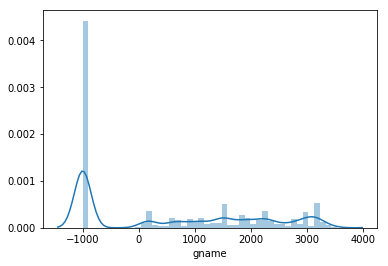

In [11]:
# Let's look at the distribution 
# The class distribution is not even and most of the data is missing
sns.distplot(train.gname)

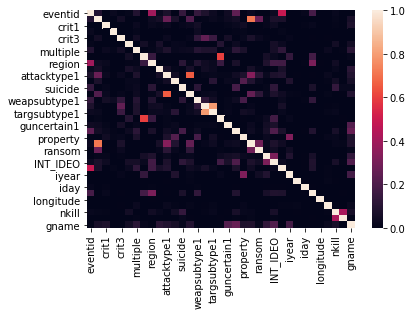

In [12]:
# Lets look at the correlation plot
# We can see that the variables iyear and count have multicollinearity and so does nkill and nkillus.
# The correlation index is not high so we can keep them.
corrmat = train.corr()
sns.heatmap(corrmat,vmin=0)

## Removing Outliers


In [13]:
# 10000 nperps is a large value by any stretch of imagination, so we will be dropping it
# removing entries with nkill > 500 Y& nkillus > 500
train[['nkill','nkillus','nperps']].describe()

,nkill,nkillus,nperps
count,181691.000000,181691.000000,181691.000000
mean,2.266860,0.029671,5.020750
std,11.241676,4.564241,163.268997
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000
max,1570.000000,1360.000000,25000.000000


In [14]:
train = train[(train.nperps<10000)]
test = test[(test.nperps<10000)]

train = train[(train.nkill<500)]
test = test[(test.nkill<500)]

train = train[(train.nkillus<500)]
test = test[(test.nkillus<500)]

In [15]:
# Creating a df to get the size
size_train = train.groupby('gname').size().to_frame().sort_values(0,ascending=False)
size_train.describe()

,0
count,3537.000000
mean,51.355386
std,1410.777254
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,82782.000000


In [16]:
# Keeping only the values that have incidents below 50
train = train.drop(list(size_train[size_train[0]<50].index),axis=0)

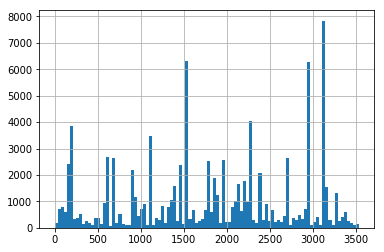

In [18]:
# The data is highly imbalanced, if the compute limit for kaggle was not limited to 6 hrs then Oversampling would have
# been performed for the minority class
train[train.gname != -999].gname.hist(bins=100)

# Validation split

In [19]:
# Using the proc_df to scales the continous variables, they will be combined again
train, train_y, nas, mapper = proc_df(train, 'gname', do_scale=True,ignore_flds=['eventid','extended','crit1','crit2',
                                                                                 'crit3','doubtterr','multiple','country','region',
                                                                                 'specificity','attacktype1','success','suicide',
                                                                                 'weaptype1','weapsubtype1','targtype1','targsubtype1',
                                                                                 'natlty1','guncertain1','claimed','property','ishostkid',
                                                                                 'ransom','INT_LOG','INT_IDEO'])

train = train.reset_index(drop=True)
train = pd.concat([train,pd.DataFrame(train_y)],axis=1,join_axes=[train.index])
train=train.rename(index=str,columns={0:'gname'})
train = train.reset_index(drop=True)

In [20]:
# Creating a function to oneHotEncode all the categorical variables since there are not ordinal
def ohe(train,features):
    """
    The functions takes the df with the list of arguments to be one hot encoded and returns a df
    train is the df and features is a list
    """
    for v in features:
        df = train[v].values
        train = train.drop([v],axis=1)
        oh = OneHotEncoder(sparse=False)
        df = df.reshape(len(df),1)
        df = oh.fit_transform(df)
        df = df[:,1:]
        train = pd.concat([train,pd.DataFrame(df)],axis=1,sort=False)
    return train

In [21]:
train = ohe(train,['country','region','specificity','attacktype1','weaptype1','weapsubtype1','targtype1','targsubtype1','natlty1'])

In [22]:
train.shape

(178318, 642)

In [24]:
# Looking at the final DataFrame
train.head()

,eventid,extended,crit1,crit2,crit3,doubtterr,multiple,success,suicide,guncertain1,claimed,property,ishostkid,ransom,INT_LOG,INT_IDEO,count,iyear,imonth,iday,latitude,longitude,nperps,nkill,nkillus,gname,0,1,2,3,4,5,6,7,8,9,10,11,12,13,...,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214
0,197002090004,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,-0.703832,2.60223,-1.318925,-0.738999,0.888287,0.001817,-0.079758,-0.263274,-0.014519,3042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,197002130002,0,1,1,1,0,0,1,0,0,0,1,0,0,0,1,-0.807589,2.60223,-1.318925,-0.284840,1.378266,0.002286,-0.079758,0.557366,-0.014519,2518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,197002210001,0,1,1,1,0,0,1,0,0,0,1,0,0,1,1,-0.859467,2.60223,-1.318925,0.623477,1.485279,0.002272,0.032918,-0.263274,-0.014519,2519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,197003030003,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0,-0.755710,2.60223,-1.023737,-1.420237,1.349695,0.001630,0.032918,-0.263274,-0.014519,3049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,197003200002,0,1,1,1,1,0,1,0,0,0,0,0,0,0,0,-0.807589,2.60223,-1.023737,0.509938,1.064209,0.001823,-0.079758,-0.146039,0.999173,3459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# Test set split
test = train[train.gname == -999]

# Training set split
train = train[train.gname!= -999]

In [26]:
test.shape

(82782, 642)

In [27]:
# Limiting the data so as to keep the compute time low
# Kaggle kernel has a limit of 6 hrs.
train = train.iloc[:50000,:]

In [28]:
# To check if any null values have crept in
train.isnull().sum().sum()

0

In [29]:
# Dropping the event ID
train.drop(['eventid'],axis='columns',inplace=True)

# Creating the split for validation
trainData, validData = train_test_split(train,test_size=0.3)

train_X, train_y, nas = proc_df(trainData, 'gname', do_scale=False)
valid_X, valid_y, nas = proc_df(validData, 'gname', do_scale=False)

In [30]:
train_X.shape,train_y.shape,valid_X.shape,valid_y.shape

((35000, 640), (35000,), (15000, 640), (15000,))

# Training the model

In [31]:
# The SVC model had the best overall accruaracy score among the models tested
# Using the best results from GridSearch
est = SVC(C=1, gamma=4, kernel='poly', degree=3, max_iter=10000, class_weight='balanced')

In [ ]:
# Fitting the training data
est.fit(train_X,train_y)

In [ ]:
# Making the prediction
y_pred = est.predict(valid_X)

In [ ]:
# Checking the accruracy and F1 score
accuracy_score(valid_y,y_pred)

In [ ]:
f1_score(valid_y,y_pred,average='macro')

In [ ]:
# The model was run 4 times to get the average accuracy and f1 score, this is done as the time complexity would be high for performing 
# K-fold cross validation
# avg accuracy = 68 % which is the best for among the models tested like lightGBM and KNN

# Making the final prediction

In [ ]:
test = test.reset_index(drop=True) # resetting the index of the df
test_X = test.drop(['eventid','gname'],axis='columns') # Dropping the event ID
test_pred = est.predict(test_X) # making the prediction
test_pred = le.inverse_transform(test_pred) # inverse transform
pred = pd.DataFrame(test_pred) # converting the array into a df

In [ ]:
# The indexes are same so they can be combined.
test.index,pred.index

In [ ]:
final = pd.concat([test.eventid,pred],axis=1,join_axes=[test.index]) # combining the final data

final.to_csv('Final_pred.csv') # Exporting it to csv file 